# Prepare data for training

In [1]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

from sklearn.utils import class_weight

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

import shutil

import imageio
import cv2

### Imfusion Lables Preparation

export .txt file and convert segmentation masks to unsigned char for ImFusion Label annotations

In [2]:
# move only the fully preprocessed files into new patient folders
path_to_auto_segmented_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/segmented_AURORA_n4_20240614-170748")
path_to_all_preprocessed_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")
path_to_unsigned_segmentations = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations")

path_to_txt_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/files_to_segment.txt"

In [4]:
# create txt file that lists all the paths to the preprocessed t1c images and after that separated by a semi-colon the path to the multilabel segmentation

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    t1c_file = [file for file in os.listdir(str(path_to_perc_normalized)) if "t1c" in file][0]
    path_to_t1c_file = path_to_perc_normalized / t1c_file

    path_to_segmentation = path_to_auto_segmented_files / patient
    if not path_to_segmentation.exists():
        print(f"directory {path_to_segmentation} does not exist")
        continue

    multimodal_segmentation_file = [file for file in os.listdir(str(path_to_segmentation)) if "multi-modal" in file][0]
    path_to_multimodal_segmentation_file = path_to_segmentation / multimodal_segmentation_file

    mask = nib.load(path_to_multimodal_segmentation_file)
    data = mask.get_fdata()

    # Convert to unsigned bytes
    data_uint8 = data.astype(np.uint8)

    # Create a new Nifti1Image
    new_img = nib.Nifti1Image(data_uint8, affine = mask.affine)

    new_img.header.set_data_dtype(np.uint8)
    new_img.header['datatype'] = 2  # 2 corresponds to unsigned char in NIfTI format
    new_img.header['bitpix'] = 8  # 8 bits per voxel

    path_to_unsinged_mask = path_to_unsigned_segmentations / multimodal_segmentation_file

    nib.save(new_img, path_to_unsinged_mask)

    f = open(path_to_txt_file, "a")
    f.write(f"{path_to_t1c_file};{path_to_unsinged_mask}\n")
    f.close()

  0%|          | 0/492 [00:00<?, ?it/s]


ImageFileError: Cannot work out file type of "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/segmented_AURORA_n4_20240614-170748/sub-01812518/sub-01812518_multi-modal_segmentation.nii.gz"

In [13]:
output_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations/sub-01009590_multi-modal_segmentation.nii.gz"

img = nib.load(output_file)
print(img.get_data_dtype())  # This should print uint8

uint8


prints patients that have been removed from the training

In [4]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

training_patients = pd.read_csv(path_to_tsv, sep="\t")

patient_ids = training_patients["participant_id"].tolist()
print(patient_ids)

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in preprocessed_patients:
    if patient not in patient_ids:
        print(patient)

['sub-01005097', 'sub-01005630', 'sub-01006290', 'sub-01009590', 'sub-01015961', 'sub-01018613', 'sub-01021714', 'sub-01021993', 'sub-01022787', 'sub-01025630', 'sub-01031243', 'sub-01038520', 'sub-01040149', 'sub-01041137', 'sub-01055292', 'sub-01056598', 'sub-01056884', 'sub-01064662', 'sub-01071055', 'sub-01072344', 'sub-01083248', 'sub-01087386', 'sub-01098043', 'sub-01099901', 'sub-01104996', 'sub-01106844', 'sub-01108350', 'sub-01109318', 'sub-01111974', 'sub-01117914', 'sub-01117958', 'sub-01119720', 'sub-01122863', 'sub-01125016', 'sub-01130173', 'sub-01130856', 'sub-01131702', 'sub-01134825', 'sub-01138456', 'sub-01147272', 'sub-01150136', 'sub-01152379', 'sub-01164049', 'sub-01164986', 'sub-01169240', 'sub-01188297', 'sub-01189050', 'sub-01190670', 'sub-01190738', 'sub-01196057', 'sub-01199093', 'sub-01201117', 'sub-01201482', 'sub-01204563', 'sub-01205171', 'sub-01205745', 'sub-01207036', 'sub-01213140', 'sub-01214172', 'sub-01214417', 'sub-01216717', 'sub-01220269', 'sub-01

In [5]:
import nibabel as nib
import numpy as np

# Load the .nii file
img = nib.load('path_to_your_label.nii')
data = img.get_fdata()

# Convert to unsigned bytes
data_uint8 = data.astype(np.uint8)

# Create a new Nifti1Image
new_img = nib.Nifti1Image(data_uint8, img.affine, img.header)

# Save the new .nii file
nib.save(new_img, 'path_to_your_label_uint8.nii')

FileNotFoundError: No such file or no access: 'path_to_your_label.nii'

In [4]:
# copy preprocessed files into new patient folders
preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    path_to_new_patient_folder = path_to_only_preprocessed / patient
    os.mkdir(path_to_new_patient_folder)

    files_to_copy = [file for file in os.listdir(str(path_to_perc_normalized)) if not file.endswith(".nii.gz")]

    for file in files_to_copy:
        shutil.copy(path_to_perc_normalized / file, path_to_new_patient_folder)

## Regensburg

### Clean up data

CAVE: remove patient sub-01383503 from training as the cerebellum is not fully displayed

In [5]:
# set pandas random seed to 42
np.random.seed(42)

In [6]:
#path_to_patients_tsv = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/rawdata/participants.tsv")
#path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv")
path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/participants_04_09_24.tsv")

# old: path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
# path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
#path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")
path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")

Read .tsv file with all the patients

In [7]:
training_patients = pd.read_csv(path_to_patients_tsv, sep="\t", index_col=False)

# drop patient sub-01383503
patient_to_drop_index = training_patients.index[training_patients["participant_id"] == "sub-01383503"]
training_patients.drop(index=patient_to_drop_index, inplace=True)
training_patients.reset_index(drop=True, inplace=True)
#training_patients = training_patients.sample(frac=1) #shuffles the dataset

print(f"Before removing unfit files: {len(training_patients)}")
patient_files_list = os.listdir(path_to_preprocessed_images)
for index, row in training_patients.iterrows():
    if training_patients["participant_id"][index] not in patient_files_list:
        training_patients.drop(index=index, inplace=True)

print(f"After removing unfit files: {len(training_patients)}")
training_patients.reset_index(drop=True, inplace=True)

# shuffle dataset
training_patients = training_patients.sample(frac=1).reset_index(drop=True)

patient_ids = training_patients["participant_id"].tolist()

Before removing unfit files: 472
After removing unfit files: 470


### Unify primary classes

In [ ]:
#copy of cancer_primaries_dict from config.py (22_07_2024)

# cancer_primaries_dict = {   '1a': 'small cell lung cancer',
#                             '1b': 'squamous cell lung cancer',
#                             '1c': 'adenocarcinoma of the lung',
#                             '1d': 'large cell lung cancer',
#                             '1e': 'NSCLC',
#                             '1f': 'lung cancer, other',
#                             '1g': 'lung cancer, exact histology unknown',
#                             '2': 'breast cancer',
#                             '3': 'prostate cancer',
#                             '4': 'testicular cancer',
#                             '5': 'renal cell carcinoma',
#                             '6': 'transitional cell carcinoma', # also called urothelial carcinoma
#                             '7': 'vulvar carcinoma',
#                             '8': 'cervical cancer',
#                             '9': 'endometrial cancer',
#                             '10': 'ovarian cell carcinoma',
#                             '11a': 'osteosarcoma',
#                             '11b': 'liposarcoma',
#                             '11c': 'leiomyosarcoma',
#                             '11d': 'rhabdomyosarcoma',
#                             '11e': 'synovial sarcoma',
#                             '11f': 'solitary fibrous tumor',
#                             '11g': 'sarcoma, other',
#                             '11h': 'sarcoma, exact histology unknown',
#                             '12': 'melanoma',
#                             '13': 'lacrimal gland carcinoma',
#                             '14': 'salivary gland cancer',
#                             '15': 'oral squamous cell carcinoma',
#                             '16': 'adenoid cystic carcinoma',
#                             '17': 'laryngeal cancer',
#                             '18': 'thyroid cancer',
#                             '19': 'esophageal cancer',
#                             '20': 'gastric cancer',
#                             '21': 'pancreatic cancer',
#                             '22': 'cholangiocellular carcinoma',
#                             '23': 'colorectal cancer',
#                             '24': 'NET', # = neuroendocrine tumors
#                             '25': 'MiNEN', # = mixed neuroendocrine non-neuroendocine neuroplasms
#                             '26a': 'DSRCT', # = Desmoplastic small-round-cell Tumor
#                             '26b': 'mesothelioma, other',
#                             '27': 'thymoma',
#                             '28': 'plasmacytoma',
#                             '29': 'cancer of unknown primary'
# }

In [8]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()

print("Original Primaries Dict:")
print(primaries_array_dict)
print()

def compress_primaries_dict(primaries_dict):

    #primaries_dict_copy = primaries_dict.copy()

    for key, value in primaries_dict.items():
        clean_primary = ''.join(filter(str.isdigit, value))
        primaries_dict[key] = clean_primary
    
    print(primaries_dict)

    for key, value in primaries_dict.items():
        primary_num = int(value)

        renamed_primary = 0

        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num

        primaries_dict[key] = renamed_primary
    
    print(primaries_dict)
    return primaries_dict


def return_specific_primaries_dict(primaries_dict, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    
                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101

                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 12:
                            primaries_dict[key] = 102
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 103
                case 4: # genito urinary

                    for key, value in primaries_dict.items():
                        if value == 3:
                            primaries_dict[key] = 104
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 19:
                            primaries_dict[key] = 105
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101
                    #primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 4:
                            primaries_dict[key] = 102
                    #primaries_array = primaries_array.replace(4, 102)
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 103
                    #primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    
                    for key, value in primaries_dict.items():
                        if value == 6:
                            primaries_dict[key] = 104
                    #primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 105
                    #primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    print(primaries_dict)

    for key, value in primaries_dict.items():
        if value < 100:
            primaries_dict[key] = 0

    print(primaries_dict)

    counter = 0

    for specific_class in specific_classes:
        specific_class = specific_class + 100
        counter += 1

        for key, value in primaries_dict.items():
            if value == specific_class:
                primaries_dict[key] = counter
    
    print(primaries_dict)

    return primaries_dict

print("Compress Primaries Dict Function output:")
compressed = compress_primaries_dict(primaries_array_dict)
print()

print("Return Specific Primaries Dict Function output:")
specific_primaries_dict = return_specific_primaries_dict(compressed, [1,2,3,4,5], "Regensburg")

print(pd.Series(specific_primaries_dict.values()).value_counts())

Original Primaries Dict:
{'sub-01205745': '12', 'sub-01288350': '23', 'sub-01125016': '11b', 'sub-02184584': '1c', 'sub-02146286': '1a', 'sub-01710250': '1c', 'sub-01686968': '1f', 'sub-01025630': '1a', 'sub-02055312': '1c', 'sub-01281168': '12', 'sub-01314225': '1b', 'sub-02178883': '1c', 'sub-02127770': '2', 'sub-02154718': '1c', 'sub-80011453': '2', 'sub-02139997': '1e', 'sub-01515235': '12', 'sub-01381621': '8', 'sub-02148372': '10', 'sub-01311383': '1c', 'sub-01005097': '1e', 'sub-93003757': '5', 'sub-01038520': '1a', 'sub-01771120': '1a', 'sub-01309950': '23', 'sub-01677324': '12', 'sub-02174928': '2', 'sub-01307298': '1a', 'sub-01117958': '1f', 'sub-01587295': '6', 'sub-01421533': '1c', 'sub-01732889': '1c', 'sub-01398968': '1a', 'sub-02124336': '1a', 'sub-01071055': '5', 'sub-01147272': '1a', 'sub-02095181': '15', 'sub-93002557': '23', 'sub-01947074': '23', 'sub-01484016': '12', 'sub-01895825': '12', 'sub-01773716': '1e', 'sub-01505384': '12', 'sub-01565091': '23', 'sub-0201573

In [17]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()
primaries_array = training_patients["primary"]

#print(primaries_array)

#print(primaries_array.value_counts())




def compress_primaries(primaries_array):
    '''moves all the primaries from different subclasses into one class, e.g. 1a-f become 1 etc.'''
    
    letters_removed_primaries = []

    # remove any letters from the list
    for primary in primaries_array:
        clean_primary = ''.join(filter(str.isdigit, primary))
        letters_removed_primaries.append(clean_primary)

    compressed_primaries = []

    for primary in letters_removed_primaries:
        primary_num = int(primary)
        renamed_primary = 0
        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num
        
        compressed_primaries.append(renamed_primary)
        
    return compressed_primaries

compressed_list = pd.Series(compress_primaries(primaries_array))
#print(compressed_list.value_counts())

def return_specific_primaries(primaries_array, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(1, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(12, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(2, 103)
                case 4: # genito urinary
                    primaries_array = primaries_array.replace(3, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(19, 105)
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(4, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    for primary in primaries_array:
            if primary < 100:
                primaries_array = primaries_array.replace(primary, 0)
    
    counter = 0

    for specific_class in specific_classes:
        
        specific_class = specific_class + 100

        counter += 1

        primaries_array = primaries_array.replace(specific_class, counter)

    #print(primaries_array.value_counts())

    return primaries_array

def return_modified_primaries(primaries_array, num_classes):
    '''returns an array where all the items are grouped into x classes depending on num_classes
    e.g. if num_classes = 2, then only the most frequent category (lung cancer) gets returned while all the other categories are grouped as \'other\''''
    
    # get most frequent classes
    # go through the list and replace each item that is not in the most frequent classes with "other"
    # the following code is probably one the least efficient ways to solve this problem
    # but it works so who am I to change it
    different_primaries = []

    for primary in primaries_array:
        if primary not in different_primaries:
            different_primaries.append(primary)
    
    count_dict = {}

    #print(different_primaries)

    for dif_primary in different_primaries:
        count = list(primaries_array).count(dif_primary)
        count_dict[count] = dif_primary
    
    sorted_dict = sorted(count_dict, reverse=True)

    white_list_count = []

    for n in range(num_classes - 1):
        white_list_count.append(sorted_dict[n])

    white_list = []
    for n in white_list_count:
        white_list.append(count_dict[n])

    modified_array = []

    for primary in primaries_array:
        modified_primary = 0

        if primary not in white_list:
            modified_primary = 0
        else:
            modified_primary = primary
        
        modified_array.append(modified_primary)
    
    return modified_array

test_class_primaries = return_specific_primaries(compressed_list, specific_classes = [1,2,3,4,5], dataset="Regensburg")
#print(test_class_primaries)
print(test_class_primaries.value_counts())
# two_classes_primaries = pd.Series(return_modified_primaries(compressed_list, num_classes=2))

# print(two_classes_primaries)
# print(two_classes_primaries.value_counts())

# # create dict of patient IDs to primaries
patient_primaries_dict = dict(zip(patient_ids, test_class_primaries))
print(patient_primaries_dict)

1    255
2     74
4     42
3     39
5     32
0     28
Name: count, dtype: int64
{'sub-01205745': 2, 'sub-01288350': 5, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 1, 'sub-01686968': 1, 'sub-01025630': 1, 'sub-02055312': 1, 'sub-01281168': 2, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 3, 'sub-02154718': 1, 'sub-80011453': 3, 'sub-02139997': 1, 'sub-01515235': 2, 'sub-01381621': 4, 'sub-02148372': 4, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 4, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 5, 'sub-01677324': 2, 'sub-02174928': 3, 'sub-01307298': 1, 'sub-01117958': 1, 'sub-01587295': 4, 'sub-01421533': 1, 'sub-01732889': 1, 'sub-01398968': 1, 'sub-02124336': 1, 'sub-01071055': 4, 'sub-01147272': 1, 'sub-02095181': 0, 'sub-93002557': 5, 'sub-01947074': 5, 'sub-01484016': 2, 'sub-01895825': 2, 'sub-01773716': 1, 'sub-01505384': 2, 'sub-01565091': 5, 'sub-02015730': 1, 'sub-01432274': 2, 'sub-01942928': 3, 'sub-01288245': 4, 'sub-01

### One hot encode sex

In [18]:
# 0 = male
# 1 = female

sex_array_dict = pd.Series(training_patients["sex (m/f)"].values, index=training_patients.participant_id).to_dict()

for key, value in sex_array_dict.items():
    if value == "m":
        sex_array_dict[key] = 0
    elif value == "f":
        sex_array_dict[key] = 1
    else:
        print(f"unknown sex: {value}")

print(sex_array_dict)

sex_array = training_patients["sex (m/f)"]

print(sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

sex_encoded = []

for sex in sex_array:
    if sex == "m":
        sex_encoded.append(0)
    elif sex == "f":
        sex_encoded.append(1)
    else:
        print(f"unknown sex: {sex}")
        #sex_encoded.append([0, 0])

print(sex_encoded)
sex_encoded_dict = dict(zip(patient_ids, sex_encoded))

{'sub-01205745': 0, 'sub-01288350': 1, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 0, 'sub-01686968': 1, 'sub-01025630': 0, 'sub-02055312': 0, 'sub-01281168': 0, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 1, 'sub-02154718': 0, 'sub-80011453': 1, 'sub-02139997': 0, 'sub-01515235': 1, 'sub-01381621': 1, 'sub-02148372': 1, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 0, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 0, 'sub-01677324': 0, 'sub-02174928': 1, 'sub-01307298': 1, 'sub-01117958': 0, 'sub-01587295': 0, 'sub-01421533': 0, 'sub-01732889': 0, 'sub-01398968': 0, 'sub-02124336': 1, 'sub-01071055': 0, 'sub-01147272': 0, 'sub-02095181': 0, 'sub-93002557': 1, 'sub-01947074': 0, 'sub-01484016': 0, 'sub-01895825': 0, 'sub-01773716': 0, 'sub-01505384': 0, 'sub-01565091': 1, 'sub-02015730': 0, 'sub-01432274': 0, 'sub-01942928': 1, 'sub-01288245': 1, 'sub-01373833': 1, 'sub-01450871': 0, 'sub-02137062': 0, 'sub-01882333': 0, 'sub-016521

### 2D Images

#### Prepare Images For Training
- load png files
- give options to load mask or cutout
- rotate images 90 degress?
- compress all sequences into one array 

In [10]:
path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")
#path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_test_slices")

In [9]:
def load_2d_rgb_image(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):
    # order of sequences t1, t1c, t2, flair, maybe mask

    if save_as_rgb:
        imread_flag = cv2.IMREAD_COLOR  # 1
    else: # save as a single gray scale image
        imread_flag = cv2.IMREAD_GRAYSCALE  # 0

    leasions = []
    leasion_ids = {}


    patient_files = [file for file in os.listdir(path_to_sliced_images / patient_id) if file.endswith(".png")]

    leasion_layers = []

    counter = 0

    # adds leasions to the leasion_ids dictionary
    for file in patient_files:

        leasion = int(file.split("_")[3])

        if leasion not in leasion_ids.values():
            leasion_ids[counter] = leasion
            counter += 1


    # goes through all the leasions
    for leasion in range(len(leasion_ids.keys())):
        
        leasion_files = [
            file for file in patient_files
            if int(file.split("_")[3]) == (leasion_ids[leasion])
        ]

        leasion_layer = int(leasion_files[0].split("_")[2])
        #print(f"Leasion Layer = {leasion_layer}")

        leasion_layers.append(leasion_layer)
        
        t1_image = None
        t1c_image = None
        t2_image = None
        flair_image = None
        mask_image = None

        if only_cutout == True:
            # load only cutout of t1, t1c, t2, flair
            leasion_files = [file for file in leasion_files if "cutout" in file]

            for file in leasion_files:
                sequence = file.split("_")[-2]

                path_to_file = str(path_to_sliced_images / patient_id / file)

                bgr_img = cv2.imread(path_to_file, imread_flag)
                # If saving as RGB, convert from BGR -> RGB
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                match sequence:
                    case "t1":
                        t1_image = bgr_img
                    case "t1c":
                        t1c_image = bgr_img
                    case "t2":
                        t2_image = bgr_img
                    case "fla":
                        flair_image = bgr_img
                    case _:
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]

        elif include_mask == True:
            # load t1, t1c, t2, flair, mask image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]

                bgr_img = cv2.imread(path_to_file, imread_flag)
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                
                match sequence:
                    case "t1":
                        t1_image = bgr_img
                    case "t1c":
                        t1c_image = bgr_img
                    case "t2":
                        t2_image = bgr_img
                    case "fla":
                        flair_image = bgr_img
                    case _:
                        pass

                if file.endswith("mask.png") and mask_image is None:
                    mask_image = bgr_img #previously: mask_image = cv2.imread(path_to_file, 0)

            images = [t1_image, t1c_image, t2_image, flair_image, mask_image]

        else:
            # load t1, t1c, t2, flair image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]

                bgr_img = cv2.imread(path_to_file, imread_flag)
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                
                match sequence:
                    case "t1":
                        t1_image = bgr_img
                    case "t1c":
                        t1c_image = bgr_img
                    case "t2":
                        t2_image = bgr_img
                    case "fla":
                        flair_image = bgr_img
                    case _:
                        #print("Wrong sequence set in the load_2d_rgb_image func, please pick a sequence between t1, t1c, t2, flair")
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]
        
        leasions.append(images)
    
    return leasions, leasion_layers

def merge_2d_rgb_images(leasions):

    merged = []

    for leasion in leasions:
        stacked = tf.stack(leasion, axis = -1)
        merged.append(stacked)
    
    return tf.convert_to_tensor(merged)

def prepare_2d_rgb_images(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):

    leasions, leasion_layers = load_2d_rgb_image(patient_id, include_mask, only_cutout, save_as_rgb)
    merged = merge_2d_rgb_images(leasions)

    if len(leasions) != len(leasion_layers):
        print("ERROR! Amount of leasions is not equal to the amount of leasion_layers")

    return merged, leasion_layers

(240, 240, 3)


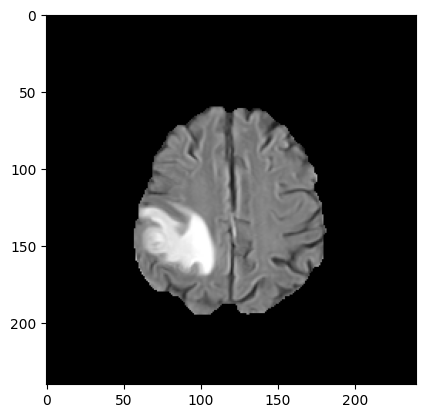

In [21]:
leasions, leasion_layers = load_2d_rgb_image(patient_id = "sub-01134825",
                             include_mask = True,
                             only_cutout = False,
                             save_as_rgb = True)

#print(leasions[0].shape)

plt.imshow(leasions[0][3], cmap = "gray")

print(leasions[0][1].shape)

merged = merge_2d_rgb_images(leasions)

#merged = merge_2d_rgb_images(leasions)
# plt.imshow(merged[0][:,:,2], cmap = "gray")

#### Data Augmentation

custom layer that adjusts all pixel values to be between 0 and 1

In [6]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized

Random Rescaling Custom Layer

In [16]:
class RandomRescale(tf.keras.layers.Layer):
    def __init__(self, scale_range=(0.8, 1.2), **kwargs):
        """
        Custom layer for random rescaling of images.
        Args:
            scale_range (tuple): A tuple specifying the minimum and maximum scaling factors.
                                 Values < 1.0 zoom out, and > 1.0 zoom in.
        """
        super(RandomRescale, self).__init__(**kwargs)
        self.scale_range = scale_range

    def call(self, inputs, training=None):
        if training:
            # Randomly choose a scaling factor
            scale = tf.random.uniform([], self.scale_range[0], self.scale_range[1])
            
            # Get image dimensions
            input_shape = tf.shape(inputs)
            #height, width = input_shape[1], input_shape[2]
            height, width = input_shape[0], input_shape[1]
            
            # Compute new dimensions
            new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
            new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
            
            # Resize image to new dimensions
            scaled_image = tf.image.resize(inputs, [new_height, new_width])
            
            # Crop or pad to original size
            scaled_image = tf.image.resize_with_crop_or_pad(scaled_image, height, width)
            
            return scaled_image
        else:
            return inputs

    def get_config(self):
        config = super(RandomRescale, self).get_config()
        config.update({"scale_range": self.scale_range})
        return config


a simple data augmentation protocol that includes
- horizontal flip
- rescaling to 0 - 1
- random contrast
- random brightness
- random rotation
- rescaling again lol
- random translatio

I had to rescale the images again using a custom layer, so that all images values are between 0 and 1 in the end

input shape: (240, 240, 5)
augmented shape: (240, 240, 5)
Max value: 0.99750924
Mean value: 0.27595377
Min value: 0.0


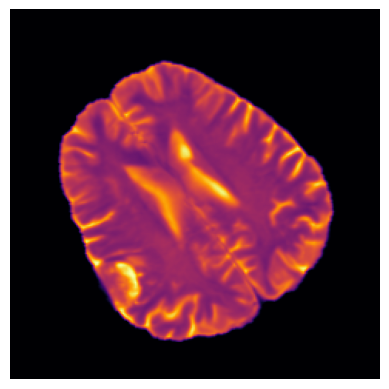

In [231]:
patient_images = merge_2d_rgb_images(load_2d_rgb_image(patient_id = "sub-01921604",
                            include_mask = True,
                            only_cutout = False)[0])[1]
print(f"input shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.14, 0.14), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    ),
    RandomRescale(scale_range=(0.7, 1.2))
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

print(f"augmented shape: {augmented_images.shape}")

plt.imshow(np.array(augmented_images[:,:,2]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Mean value:", np.array(augmented_images).mean())
print("Min value:", np.array(augmented_images).min())

### Class weight calculation for weighted loss

In [11]:
# Insert this as a new code cell (e.g., Cell 30)

print("--- Calculating Lesion-Level Label Distribution ---")

# Ensure prerequisite variables and functions are available
if 'specific_primaries_dict' not in locals() or 'patient_ids' not in locals():
    raise NameError("ERROR: 'specific_primaries_dict' or 'patient_ids' is not defined. "
                    "Please run the notebook cells that define these variables first (Cells 13 & 17).")
if 'load_2d_rgb_image' not in locals():
    raise NameError("ERROR: 'load_2d_rgb_image' function is not defined (Cell 20).")
if 'path_to_sliced_images' not in locals():
    raise NameError("ERROR: 'path_to_sliced_images' is not defined (Cell 19).")


all_lesion_labels = []
# Get a list of patient subfolders actually present in path_to_sliced_images
available_sliced_patients = [p for p in os.listdir(path_to_sliced_images) if os.path.isdir(os.path.join(path_to_sliced_images, p))]

# Filter patient_ids to only include those present in both path_to_sliced_images AND specific_primaries_dict
valid_patient_ids_for_lesion_count = [
    pid for pid in patient_ids
    if pid in available_sliced_patients and pid in specific_primaries_dict
]

# Report any discrepancies
missing_in_slices = set(patient_ids) - set(available_sliced_patients)
if missing_in_slices:
    print(f"Warning: The following patients from 'patient_ids' are not in 'path_to_sliced_images' and will be skipped: {missing_in_slices}")

missing_in_dict = set(patient_ids) - set(specific_primaries_dict.keys())
if missing_in_dict:
     print(f"Warning: The following patients from 'patient_ids' are not in 'specific_primaries_dict' and will be skipped: {missing_in_dict}")


for pat_id in tqdm(valid_patient_ids_for_lesion_count, desc="Counting lesions per patient"):
    try:
        # The parameters include_mask, only_cutout, save_as_rgb for load_2d_rgb_image
        # should not affect the *number* of lesions found.
        # We use include_mask=True as it's used in the TFRecord creation logic (Cell 22)
        # and save_as_rgb=False as the base image loading is typically grayscale before potential RGB stacking.
        lesions_data, _ = load_2d_rgb_image(
            patient_id=pat_id,
            include_mask=True,
            only_cutout=False,
            save_as_rgb=False
        )
        num_lesions_for_patient = len(lesions_data)
        
        if num_lesions_for_patient == 0:
            print(f"Warning: Patient {pat_id} has 0 lesions. Skipping.")
            continue
            
        primary_class_for_patient = specific_primaries_dict[pat_id]
        all_lesion_labels.extend([primary_class_for_patient] * num_lesions_for_patient)
        
    except FileNotFoundError:
        print(f"Warning: Sliced image data not found for patient {pat_id} in {path_to_sliced_images / pat_id}. Skipping this patient.")
    except Exception as e:
        print(f"Error processing patient {pat_id}: {e}. Skipping this patient.")

# This series now represents the primary class (0-5) for each individual lesion
lesion_labels_in_tfrecord_series = pd.Series(all_lesion_labels)

print("\nLesion-Level Label Distribution (0-5 classes, as would be in TFRecords):")
if not lesion_labels_in_tfrecord_series.empty:
    print(lesion_labels_in_tfrecord_series.value_counts().sort_index())
    print(f"Total number of lesions processed: {len(all_lesion_labels)}")
else:
    print("No lesion labels were generated. Please check patient data and paths.")

print("--- Finished Calculating Lesion-Level Label Distribution ---")

--- Calculating Lesion-Level Label Distribution ---


Counting lesions per patient:  23%|██▎       | 106/470 [00:01<00:06, 58.20it/s]

Counting lesions per patient:  34%|███▎      | 158/470 [00:02<00:03, 88.96it/s]

Counting lesions per patient:  42%|████▏     | 199/470 [00:02<00:02, 103.75it/s]

Counting lesions per patient:  49%|████▊     | 229/470 [00:02<00:02, 119.52it/s]

Counting lesions per patient:  62%|██████▏   | 293/470 [00:03<00:01, 124.83it/s]

Counting lesions per patient:  65%|██████▌   | 307/470 [00:03<00:01, 90.65it/s] 

Counting lesions per patient:  91%|█████████▏| 430/470 [00:04<00:00, 139.73it/s]

Counting lesions per patient: 100%|██████████| 470/470 [00:05<00:00, 93.84it/s] 


Lesion-Level Label Distribution (0-5 classes, as would be in TFRecords):
0     92
1    973
2    310
3    271
4     99
5     80
Name: count, dtype: int64
Total number of lesions processed: 1825
--- Finished Calculating Lesion-Level Label Distribution ---


In [12]:
# --- Class Weight Calculation Block (Simulating Training Script Parsing - LESION-BASED) ---

# IMPORTANT: Ensure this block runs *after* the cell that defines
# 'lesion_labels_in_tfrecord_series' (the new block created in Step 2)

print("--- Calculating Class Weights Based on Lesion Counts (Simulating Training Script Parsing) ---")

# Check if lesion_labels_in_tfrecord_series exists
if 'lesion_labels_in_tfrecord_series' not in locals() or lesion_labels_in_tfrecord_series.empty:
    raise NameError("ERROR: 'lesion_labels_in_tfrecord_series' is not defined or is empty. "
                    "Please run the new block that calculates lesion-level labels before this block.")

# 1. Use the base 6-class labels FOR EACH LESION (0-5)
print("\nBase Lesion-Level Label Distribution (used for TFRecords):")
print(lesion_labels_in_tfrecord_series.value_counts().sort_index())

# 2. Dictionary to store the weights for each training scenario (2-6 classes)
all_scenario_class_weights_lesion_based = {}

# 3. Loop through the possible 'num_classes' settings in the training script
for n_classes_scenario in range(2, 7): # n_classes_scenario is num_classes used during training (2, 3, 4, 5, 6)
    print(f"\n--- Simulating for num_classes = {n_classes_scenario} in training script (Lesion-Based) ---")

    # Simulate the label collapsing that would happen during training script's parse_record
    def simulate_parsing_for_lesions(label, target_n_classes):
        # In your training script, class 0 is 'other'.
        # Classes 1 to target_n_classes-1 are the specific primaries.
        # Any original label >= target_n_classes becomes 'other' (class 0).
        # Label 0 (original 'other') remains 'other' (class 0).
        if 1 <= label < target_n_classes:
            return label  # Specific primary class
        else:
            return 0      # 'Other' class

    # Apply the simulation function to the base lesion labels
    labels_after_parsing_series_lesion_based = lesion_labels_in_tfrecord_series.apply(
        lambda x: simulate_parsing_for_lesions(x, n_classes_scenario)
    )

    print(f"Lesion-Level Label Distribution *After* Simulated Parsing (num_classes={n_classes_scenario}):")
    print(labels_after_parsing_series_lesion_based.value_counts().sort_index())

    # Determine the unique classes present AFTER simulated parsing
    unique_parsed_classes_lesion_based = np.sort(labels_after_parsing_series_lesion_based.unique())
    print(f"Unique classes present after simulation (Lesion-Based): {unique_parsed_classes_lesion_based}")
    
    expected_classes_in_scenario = np.arange(n_classes_scenario)
    
    # Check for missing classes and handle warnings
    current_counts = labels_after_parsing_series_lesion_based.value_counts()
    for cls_val in expected_classes_in_scenario:
        if cls_val not in current_counts.index:
            print(f"Warning: Class {cls_val} has 0 lesions after simulating for num_classes={n_classes_scenario}. "
                  "It will be handled by class_weight='balanced' if other classes exist.")

    weights_dict_lesion_based = {}
    if len(unique_parsed_classes_lesion_based) == 0:
        print(f"Warning: No classes present after simulating for num_classes={n_classes_scenario}. Skipping weight calculation.")
    elif len(unique_parsed_classes_lesion_based) == 1:
        # If only one class remains (e.g., all are 'other'), its weight is 1.0
        weights_dict_lesion_based = {unique_parsed_classes_lesion_based[0]: 1.0}
        print(f"Warning: Only one class present after simulating for num_classes={n_classes_scenario}. Assigning weight of 1.0.")
    else:
        # Calculate weights using sklearn based on the lesion labels *after* simulated parsing
        weights = class_weight.compute_class_weight(
            class_weight="balanced",
            classes=unique_parsed_classes_lesion_based, # Use the classes actually present in the data
            y=labels_after_parsing_series_lesion_based.to_numpy()
        )
        # Store weights in a dictionary format {class_label: weight}
        weights_dict_lesion_based = {label: weight for label, weight in zip(unique_parsed_classes_lesion_based, weights)}

    all_scenario_class_weights_lesion_based[n_classes_scenario] = weights_dict_lesion_based
    print(f"Class Weights (Lesion-Based, for training with num_classes={n_classes_scenario}): {weights_dict_lesion_based}")

print("\n--- Finished Simulating and Calculating Lesion-Based Class Weights ---")
# 'all_scenario_class_weights_lesion_based' now holds the correctly calculated weights.
# Example: all_scenario_class_weights_lesion_based[2] has weights for {0: ..., 1: ...} for the 2-class case.

--- Calculating Class Weights Based on Lesion Counts (Simulating Training Script Parsing) ---

Base Lesion-Level Label Distribution (used for TFRecords):
0     92
1    973
2    310
3    271
4     99
5     80
Name: count, dtype: int64

--- Simulating for num_classes = 2 in training script (Lesion-Based) ---
Lesion-Level Label Distribution *After* Simulated Parsing (num_classes=2):
0    852
1    973
Name: count, dtype: int64
Unique classes present after simulation (Lesion-Based): [0 1]
Class Weights (Lesion-Based, for training with num_classes=2): {0: 1.0710093896713615, 1: 0.9378211716341213}

--- Simulating for num_classes = 3 in training script (Lesion-Based) ---
Lesion-Level Label Distribution *After* Simulated Parsing (num_classes=3):
0    542
1    973
2    310
Name: count, dtype: int64
Unique classes present after simulation (Lesion-Based): [0 1 2]
Class Weights (Lesion-Based, for training with num_classes=3): {0: 1.1223862238622386, 1: 0.6252141144227475, 2: 1.9623655913978495}

-

Rough Pretraining Class Weights

brain_tumor_dataset

In [ ]:
# Glioma = 0 - n(1426)
# Meningioma = 1 - n(708)
# Pituitary = 2 - n(930)

counts = {
    0: 1426,
    1: 708,
    2: 930
}

total_samples = sum(counts.values())
num_classes = len(counts)

#Calculate the class weights for each class
rough_class_weights = {}
for class_label, class_count in counts.items():
    rough_class_weights[class_label] = total_samples / (num_classes * class_count)

print(rough_class_weights)

{0: 0.7162225338943432, 1: 1.4425612052730696, 2: 1.0982078853046595}


Fine Pretraining Class Weights

In [3]:
# Glioblastoma = 0 - n(861)
# Astrocytoma (IDH-wildtype) = 1 - n(35)
# Astrocytoma (IDH-mutant) = 2 - n(133)
# Oligodendroglioma = 3 - n(55)
# Metastases = 4 - n(4063)

counts = {
    0: 861,
    1: 35,
    2: 133,
    3: 55,
    4: 4063
}

total_samples = sum(counts.values())
num_classes = len(counts)

# Calculate the class weights for each of the 5 class
fine_5_class_weights = {}
for class_label, class_count in counts.items():
    fine_5_class_weights[class_label] = total_samples / (num_classes * class_count)

print("Fine 5 Class Weights:")
print(fine_5_class_weights)
print()

# Combine classes 0 to 3 into one class and calculate the class weights
combined_class_counts = counts[0] + counts[1] + counts[2] + counts[3]
combined_num_classes = 2
combined_class_weight = total_samples / (combined_num_classes * combined_class_counts)
mets_class_weight = total_samples / (combined_num_classes * counts[4])

print("Fine combined class weights")
print(f"combined class weight: {combined_class_weight}, mets class weight: {mets_class_weight}") # combined_class_weight)

Fine 5 Class Weights:
{0: 1.1955865272938444, 1: 29.411428571428573, 2: 7.739849624060151, 3: 18.716363636363635, 4: 0.25335958651242924}

Fine combined class weights
combined class weight: 2.3740774907749076, mets class weight: 0.6333989662810731


#### TFRecord Creation

In [22]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

tf.experimental.numpy.experimental_enable_numpy_behavior()

def serialize_2d_patient(image_data, sex, age, layer, primary):

    #print(image_data.shape)

    #image_data = prepare_2d_rgb_images(patientID, include_mask = True, only_cutout = False)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value = image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value = [sex])),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value = [age])),
                'layer': tf.train.Feature(int64_list=tf.train.Int64List(value = [layer])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value= [primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

# consider addng include_mask as parameter
def writeTFRecordFiles(save_as_rgb, save_as_cutout, include_mask, only_one_patient = False):
    # Write the dataset to TFRecord
    options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

    patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

    # write a check to compare patient_ids with patients
    patients = set(patients).intersection(patient_ids)

    slice_text = "cutout" if save_as_cutout else "slice"
    color_text = "rgb" if save_as_rgb else "gray"

    folder_text = f"all_pats_single_{slice_text}_{color_text}"

    path_to_all_tfr = path_to_derivatives / Path(folder_text)

    os.makedirs(path_to_all_tfr, exist_ok=True)

    # get list of already processed patients
    tfr_already_created_patients = [patient for patient in os.listdir(path_to_all_tfr) if os.path.isdir(os.path.join(path_to_all_tfr, patient))]

    for patient in tfr_already_created_patients:
        # check if the number of leasions equals the number of tfr files
        path_to_patient = path_to_all_tfr / patient
        tfr_files = [f for f in os.listdir(path_to_patient) if f.endswith(".tfrecord")]
        num_leasions = len(tfr_files)
        leasions, leasion_layers = prepare_2d_rgb_images(patient, include_mask = include_mask, only_cutout = save_as_cutout, save_as_rgb=save_as_rgb)
        if num_leasions != len(leasions):
            # delete the patient folder
            shutil.rmtree(path_to_patient)
            tfr_already_created_patients.remove(patient)
    
    counter = 0

    # loop through patients
    for pat in tqdm(patients):

        if counter > 0 and only_one_patient:
            break

        if os.path.exists(path_to_all_tfr):
            if pat in tfr_already_created_patients:
                print(f"Skipping patient {pat}")
                continue

        # create patient folder
        path_to_patient = path_to_all_tfr / pat
        os.makedirs(path_to_patient, exist_ok=False)

        leasions, leasion_layers = prepare_2d_rgb_images(pat, include_mask = include_mask, only_cutout = save_as_cutout, save_as_rgb = save_as_rgb)
        print(f"found {len(leasions)} leasion(s) and {len(leasion_layers)} layers in patient {pat}")

        for i in range(len(leasions)):

            file_path = str(path_to_patient) + "/" + pat + "_" + str(i) + ".tfrecord"
            with tf.io.TFRecordWriter(file_path, options) as writer:

                sex = sex_array_dict[pat]
                leasion_data = leasions[i]
                age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
                layer = leasion_layers[i]
                primary = specific_primaries_dict[pat]
                # print("________________")
                # print(age)
                example = serialize_2d_patient(leasion_data, sex, age, layer, primary)
                writer.write(example)
        
        counter += 1

In [ ]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = False, include_mask = True)

In [ ]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = False, include_mask = True)

In [ ]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = True)

In [ ]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = True)

#### Read TFRecord File

Sex: 1
Age: 47
Layer: 53
Primary: 1
(240, 240, 5)
Median value: 0.0


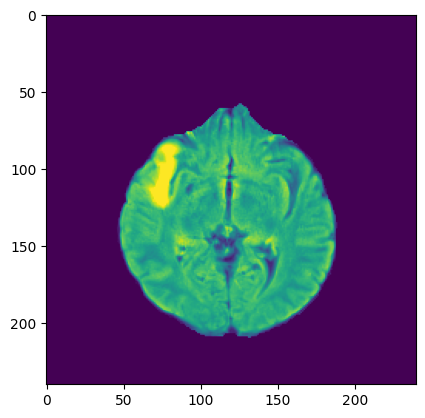

In [30]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-01190670/sub-01190670_1.tfrecord"
rgb = False

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "layer": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, image_shape) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["layer"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, layer, primary in test_image:
    print(f"Sex: {sex.numpy()}")
    print(f"Age: {age.numpy()}")
    print(f"Layer: {layer.numpy()}")
    print(f"Primary: {primary.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    # print max and min values
    print(f"Median value: {np.median(numpy_image)}")
    plt.imshow(numpy_image[:,:,3])

# sex
# m = 1, 0
# f = 0, 1

#### Get Min-Max of Age and Layer Number
Iterate over all patients to get the minimum and maximum value of the age and the layer number. This is important to normalize the values before training.

In [13]:
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

def get_min_max_age_layer():

    patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

    # write a check to compare patient_ids with patients
    patients = set(patients).intersection(patient_ids)

    ages = []
    layers = []
    
    # loop through patients
    for pat in tqdm(patients):

        leasions, leasion_layers = prepare_2d_rgb_images(pat, include_mask = False, only_cutout = False, save_as_rgb=False)

        for i in range(len(leasions)):

            age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
            ages.append(age)

            layer = leasion_layers[i]
            layers.append(layer)
    
    return min(ages), max(ages), min(layers), max(layers)

In [15]:
min_age, max_age, min_layer, max_layer = get_min_max_age_layer()

print(f"Min age: {min_age}, Max age: {max_age}, Min layer: {min_layer}, Max layer: {max_layer}")

100%|██████████| 470/470 [00:02<00:00, 168.35it/s]

Min age: 25, Max age: 93, Min layer: 0, Max layer: 138


## Yale Dataset

In [3]:
path_to_yale_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_dataset_normalized")
path_to_met_slices = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_metastases")
path_to_yale_excel = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/Pretreat-MetsToBrain-Masks_clin_20240410.xlsx")

In [6]:
yale_training_patients = pd.read_excel(path_to_yale_excel, sheet_name="Data")

yale_patient_ids = yale_training_patients["BraTS_MET_ID"].tolist()
print(yale_patient_ids)
print(len(yale_training_patients))

# preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

# for patient in preprocessed_patients:
#     if patient not in patient_ids:
#         print(patient)

[86, 89, 90, 96, 97, 98, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 260, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310]
200


### Unify primary classes

count different primaries that exist within the Yale Dataset. As one can see, most primaries belong to lung cancer (86 + 17 = 103), after that Melanoma (41), then Breast Cancer (26), Renal cell carcinoma (16) and lastly Gastrointestinal cancers (16).

In [9]:
# primaries are written like this: 1, 2, 3, 4, 5
# explanation:
# 1 = Breast cancer; 2 = Gastrointestinal cancers;
# 3 = Small cell lung cancer; 4 = Melanoma;
# 5 = Non small cell lung cancer; 6 = Renal cell carcinoma; 7 = Other

# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
yale_primaries_array = yale_training_patients["Primary"]
print(yale_primaries_array.value_counts())

Primary
5    86
4    41
1    26
3    17
6    16
2    14
Name: count, dtype: int64


Next we'll merge the two lung categories into one, meaning we combine category number 3 and category number 5 and turn it into a new category, 0.

In [14]:
# replace each 5 and 3 in the yale_primaries_array with a 0

yale_primaries_array = yale_primaries_array.replace(5, 0)
yale_primaries_array = yale_primaries_array.replace(3, 0)

print(yale_primaries_array.value_counts())

Primary
0    103
4     41
1     26
6     16
2     14
Name: count, dtype: int64


In [35]:
yale_class_primaries = return_specific_primaries(yale_primaries_array, specific_classes = [1], dataset="Yale")

print(yale_class_primaries.value_counts())

Primary
1    103
0     97
Name: count, dtype: int64
Primary
1    103
0     97
Name: count, dtype: int64


In [36]:
labels = yale_class_primaries.to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.97087379 1.03092784]


### One hot encode sex
The sex in the yale dataset is encoded as such:\
0 = Male; 1 = Female\
Then it's time to adjust the dataset accordingly:

In [40]:
yale_sex_array = yale_training_patients["Sex"]

print(yale_sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

yale_sex_encoded = []
for sex in yale_sex_array:
    if sex == 0: # Male
        yale_sex_encoded.append([1, 0])
    elif sex == 1: # Femal
        yale_sex_encoded.append([0, 1])
    else:
        print(f"unknown sex: {sex}")
        yale_sex_encoded.append([0, 0])

print(yale_sex_encoded)

Sex
1    125
0     75
Name: count, dtype: int64
[[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1],

### Prepare Images for training

#### 3D images

In [132]:
def load_yale_patient(patientID):
    images = []
    # get all four sequences

    if patientID < 100:
        patientID = "0" + str(patientID)

    patientID = str(patientID)

    patients = os.listdir(path_to_yale_preprocessed_images)
    patient_folder_name = [patient for patient in patients if patientID in patient][0]
    patient_path = Path(patient_folder_name)

    image_names = [file for file in os.listdir(path_to_yale_preprocessed_images / patient_path) if "normalized" in file]
    
    # load them
    for name in image_names:
        path_to_image = path_to_yale_preprocessed_images / patient_path / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images


def rotate_90_deg_yale(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 90)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)
    
    # return back
    return rotated_images

def merge_and_transpose_images_yale(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)

    # rearranges the sequence to order to the only correct one: T1, T1c, T2, FLAIR
    yale_sequence_order = [0, 2, 3, 1]
    new_sequence_images = transposed[..., yale_sequence_order]

    # transposed = tf.transpose(stacked, perm = new_order)
    return new_sequence_images

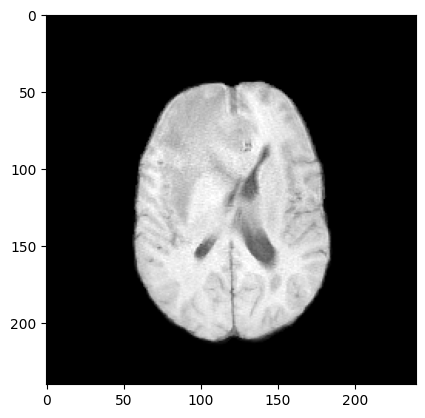

In [136]:
images = merge_and_transpose_images_yale(rotate_90_deg_yale(load_yale_patient(135)))
plt.imshow(images[80,:,:,0], cmap = "gray")

#### 2D images